# 2.1 Electricity Demand and Generation - NS

The project pulls data from the EIA API and generates charts of electricity generation and demand over a user-specified time period, in a given region, split by fuel types.

Find the API documentation here: 
- https://www.eia.gov/opendata/browser/electricity/rto/daily-region-data 
- https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48


In [1]:
# Welcome to your first deep dive lab assignment!

# In this lab, you will:
#  0. Get introduced to some terminology around utility-scale electricity demand and generation
#  1. Fetch utility-scale electricity generation and demand timeseries data from the EIA API (using python `requests` package)
#  2. Plot the data to get an understanding of how it varies over time (using Hex's built-in chart widget)
#  3. Do or find something interesting with that data. Exactly what is dependent on your coding level, see below


In [2]:
# We'll reference these terms later in the notebook, so it's important to understand them now:

# Balancing authority (BA): the organization in charge of ensuring electricity generation meets electricity demand in a given region
#   A BA performs it's own local electricity generation, and then either net imports or net exports energy to other
#   connected BAs, depending on whether local electricity demand is larger or smaller than local electricity generation

# Grid mix: electricity generation breakdown by fuel type (e.g., coal, natural gas, solar, hydro, etc.)


In [3]:
# You will run the existing notebook, but you'll update it to access data from a different balancing authority (your own local BA if US-based)

# In the next cells, we are going to:
#  1. Import 3rd party libraries
#  2. Define some data access helper functions
#  3. Set some input variables (this is where you'll make some changes!)
#  4. Fetch data
#  5. Plot and explore the data


In [4]:
# In this cell, we're importing packages that we'll use later in the notebook
# You do not need to make changes to this cell

# 1st party packages (python standard library)
import datetime
import json
import requests

# 3rd party packages
from IPython import display
import pandas as pd


In [5]:
# In this cell, we've pre-defined some helper functions you will use to fetch data from the EIA API
# You do not need to make changes to this cell

# There are three types of data we're fetching:
#  1. Generation by fuel type (Megawatt-hours): how much electricity is being generated by each fuel type
#  2. Demand (Megawatt-hours): how much electricity is being consumed
#  3. Interchange: how much electricity is being imported/exported from other balancing authorities

default_end_date = datetime.date.today().isoformat()
default_start_date = (datetime.date.today() - datetime.timedelta(days=365)).isoformat()


def get_eia_timeseries(
    url_segment,
    facets,
    value_column_name="value",
    start_date=default_start_date,
    end_date=default_end_date,
):
    """
    A generalized helper function to fetch data from the EIA API
    """

    api_url = f"https://api.eia.gov/v2/electricity/rto/{url_segment}/data/?api_key={EIA_API_KEY}"

    response_content = requests.get(
        api_url,
        headers={
            "X-Params": json.dumps(
                {
                    "frequency": "daily",
                    "data": ["value"],
                    "facets": dict(**{"timezone": ["Pacific"]}, **facets),
                    "start": start_date,
                    "end": end_date,
                    "sort": [{"column": "period", "direction": "desc"}],
                    "offset": 0,
                    "length": 5000,  # This is the maximum allowed
                }
            )
        },
    ).json()

    # Sometimes EIA API responses are nested under a "response" key. Sometimes not 🤷
    if "response" in response_content:
        response_content = response_content["response"]

    # Handle warnings by displaying them to the user
    if "warnings" in response_content:
        display.display(
            display.Markdown(f"Warning(s) returned from EIA API:"),
            response_content["warnings"],
        )
    print(f"{len(response_content['data'])} rows returned")

    # Convert the data to a Pandas DataFrame and clean it up for plotting
    dataframe = pd.DataFrame(response_content["data"])
    dataframe["timestamp"] = dataframe["period"].apply(
        pd.to_datetime, format="%Y/%m/%dT%H"
    )
    dataframe.rename(columns={"value": value_column_name}, inplace=True)
    return dataframe


def get_eia_grid_mix_timeseries(balancing_authorities, **kwargs):
    """
    Fetch electricity generation data by fuel type
    """
    return get_eia_timeseries(
        url_segment="daily-fuel-type-data",
        facets={"respondent": balancing_authorities},
        value_column_name="Generation (MWh)",
        **kwargs,
    )


def get_eia_net_demand_and_generation_timeseries(balancing_authorities, **kwargs):
    """
    Fetch electricity demand data
    """
    return get_eia_timeseries(
        url_segment="daily-region-data",
        facets={
            "respondent": balancing_authorities,
            "type": ["D", "NG", "TI"],  # Filter out the "Demand forecast" (DF) type
        },
        value_column_name="Demand (MWh)",
        **kwargs,
    )


def get_eia_interchange_timeseries(balancing_authorities, **kwargs):
    """
    Fetch electricity interchange data (imports & exports from other utilities)
    """
    return get_eia_timeseries(
        url_segment="daily-interchange-data",
        facets={"toba": balancing_authorities},
        value_column_name=f"Interchange to local BA (MWh)",
        **kwargs,
    )


In [6]:
# In this cell, you'll be making one change!

# This cell defines the local balancing authority for which we're fetching grid mix data

# Currently, we've set this to "PSEI", i.e.Puget Sound Energy, Inc., the balancing authority for the region around Seattle, WA

# Change this to a different valid balancing authority:
#  - Visit the EIA API docs here: https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48
#  - Explore the map to find the 3-4 letter acronym representing a different balancing authority
#  - Update the line below with the value you found, then re-run this cell (Shift+Enter, or use the "play" icon in the upper right of this cell)
LOCAL_BALANCING_AUTHORITY = "NYIS"


In [7]:
# In this cell, we put it all together and actually make a request against the EIA API to fetch electricity generation data
# You do not need to make changes to this cell

local_generation_grid_mix = get_eia_grid_mix_timeseries(
    [LOCAL_BALANCING_AUTHORITY],
    # Optional: uncomment the lines below to try looking at a different time range to get data from other seasons.
    start_date="2023-01-01",
    end_date="2023-12-31",
)

# Listing this variable alone on the last line causes hex to display it, so we get a preview of the data as a table
local_generation_grid_mix


NameError: name 'EIA_API_KEY' is not defined

In [ ]:
# If you're at coding level 0 or 1: Congrats, you made it through the code!

# Now, go back and play around with the data to look for interesting findings. Ideas:
#  - What is the primary electricity generation fuel type for the local balancing authority you chose? (e.g. for PSEI, it's natural gas)
#  - Is there more or less clean electricity generation than you expected?
#  - Are there any major seasonal trends?

# In your Assignment submission on the Terra.do app:
#  1. Link to your copy of this notebook
#  2. Write up a few sentences summarizing your interesting finding (you can share this in slack as well!)


## 5. Plot local generation grid mix

**Note:** The original Hex notebook had an interactive chart here. In Jupyter, you can create similar visualizations using matplotlib, plotly, or other plotting libraries. Here's an example using matplotlib:


NameError: name 'local_generation_grid_mix' is not defined

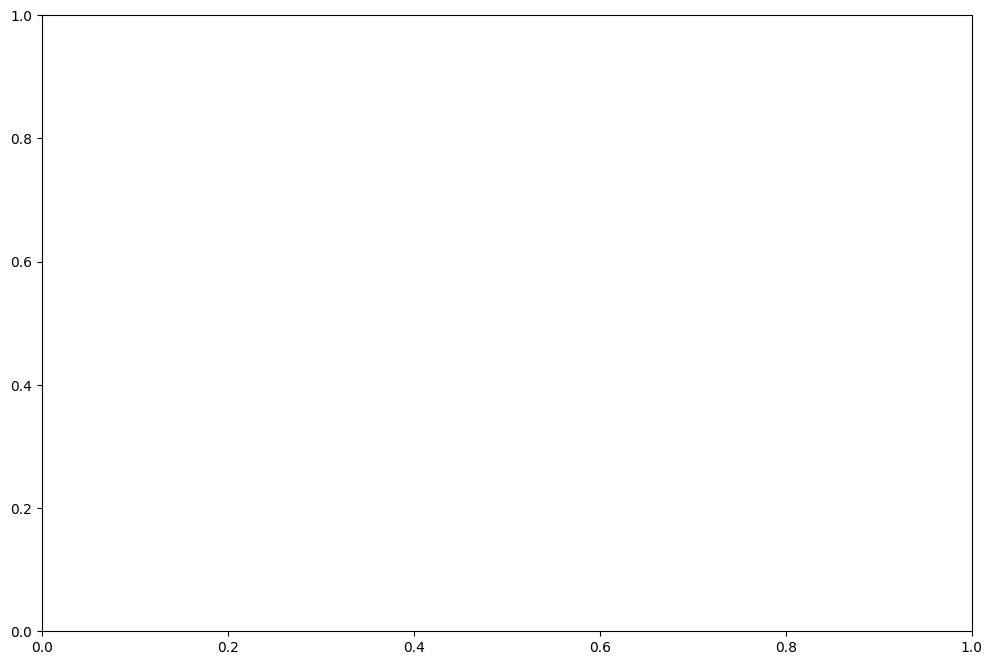

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Create a stacked area plot similar to the original Hex chart
fig, ax = plt.subplots(figsize=(12, 8))

# Group by fuel type and create stacked area plot
if not local_generation_grid_mix.empty:
    pivot_data = local_generation_grid_mix.pivot_table(
        index='timestamp', 
        columns='type-name', 
        values='Generation (MWh)', 
        fill_value=0
    )
    
    # Define colors for each fuel type (matching the original)
    colors = {
        'Coal': '#BAB0AC',
        'Wind': '#72B7B2', 
        'Hydro': '#4C78A8',
        'Other': '#FF9DA6',
        'Solar': '#EECA3B',
        'Nuclear': '#B279A2',
        'Petroleum': '#E45756',
        'Natural gas': '#9D755D'
    }
    
    # Plot stacked area chart
    ax.stackplot(pivot_data.index, 
                 *[pivot_data[col] for col in pivot_data.columns],
                 labels=pivot_data.columns,
                 colors=[colors.get(col, '#CCCCCC') for col in pivot_data.columns])
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Generation (MWh)')
    ax.set_title(f'Electricity Generation by Fuel Type - {LOCAL_BALANCING_AUTHORITY}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot. Please check your API key and data connection.")
